In [0]:
# !pip install lifelines
# !pip install h2o 
# !pip install imbalanced-learn
# !pip install lime

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
%matplotlib inline
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import lime 
import lime.lime_tabular

### 1. Preliminary Analysis 
- KEY POINTS: 
 - tenure = Time, Churn = Target, Everything Else = Possible Predictors
 - changed data type of 'TotalCharges'
 - filled in missing values

In [0]:
churn_df =pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_df.head()

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0  7590-VHVEG  Female              0  ...          29.85        29.85     No
1  5575-GNVDE    Male              0  ...          56.95       1889.5     No
2  3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3  7795-CFOCW    Male              0  ...          42.30      1840.75     No
4  9237-HQITU  Female              0  ...          70.70       151.65    Yes

[5 rows x 21 columns]

In [0]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [0]:
# Notice that TotalCharges column is in object data type. We need to change it back to float.
churn_df["TotalCharges"] = pd.to_numeric(churn_df["TotalCharges"],errors='coerce')

In [0]:
# Count missing values
churn_df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [0]:
# Inspect the rows with missing value
churn_df[churn_df['TotalCharges'].isnull()]

customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
488   4472-LVYGI  Female              0  ...          52.55          NaN     No
753   3115-CZMZD    Male              0  ...          20.25          NaN     No
936   5709-LVOEQ  Female              0  ...          80.85          NaN     No
1082  4367-NUYAO    Male              0  ...          25.75          NaN     No
1340  1371-DWPAZ  Female              0  ...          56.05          NaN     No
3331  7644-OMVMY    Male              0  ...          19.85          NaN     No
3826  3213-VVOLG    Male              0  ...          25.35          NaN     No
4380  2520-SGTTA  Female              0  ...          20.00          NaN     No
5218  2923-ARZLG    Male              0  ...          19.70          NaN     No
6670  4075-WKNIU  Female              0  ...          73.35          NaN     No
6754  2775-SEFEE    Male              0  ...          61.90          NaN     No

[11 rows x 21 columns]

- From the inspection table above we could see that the missing values are probably due to system error. Because those customers all have 0 in 'tenure' column, which means they are all new customers. So I'll set every the missing value in 'TotalCharges' column equals to its 'MonthlyCharges'. 



In [0]:
idx = churn_df[churn_df['TotalCharges'].isnull()].index.tolist()
churn_df.loc[idx,'TotalCharges'] = churn_df.loc[idx,'MonthlyCharges']

### 2. EXPLORATORY DATA ANALYSIS
- Explored categorical and numerical columns
- Noticed the imbalanced distribution of target variable
- Transformed categorical columns using one hot encoding
- Identified customer churn problem using survival analysis

In [0]:
categorical_columns = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService'
,'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling'
,'PaymentMethod','Churn']

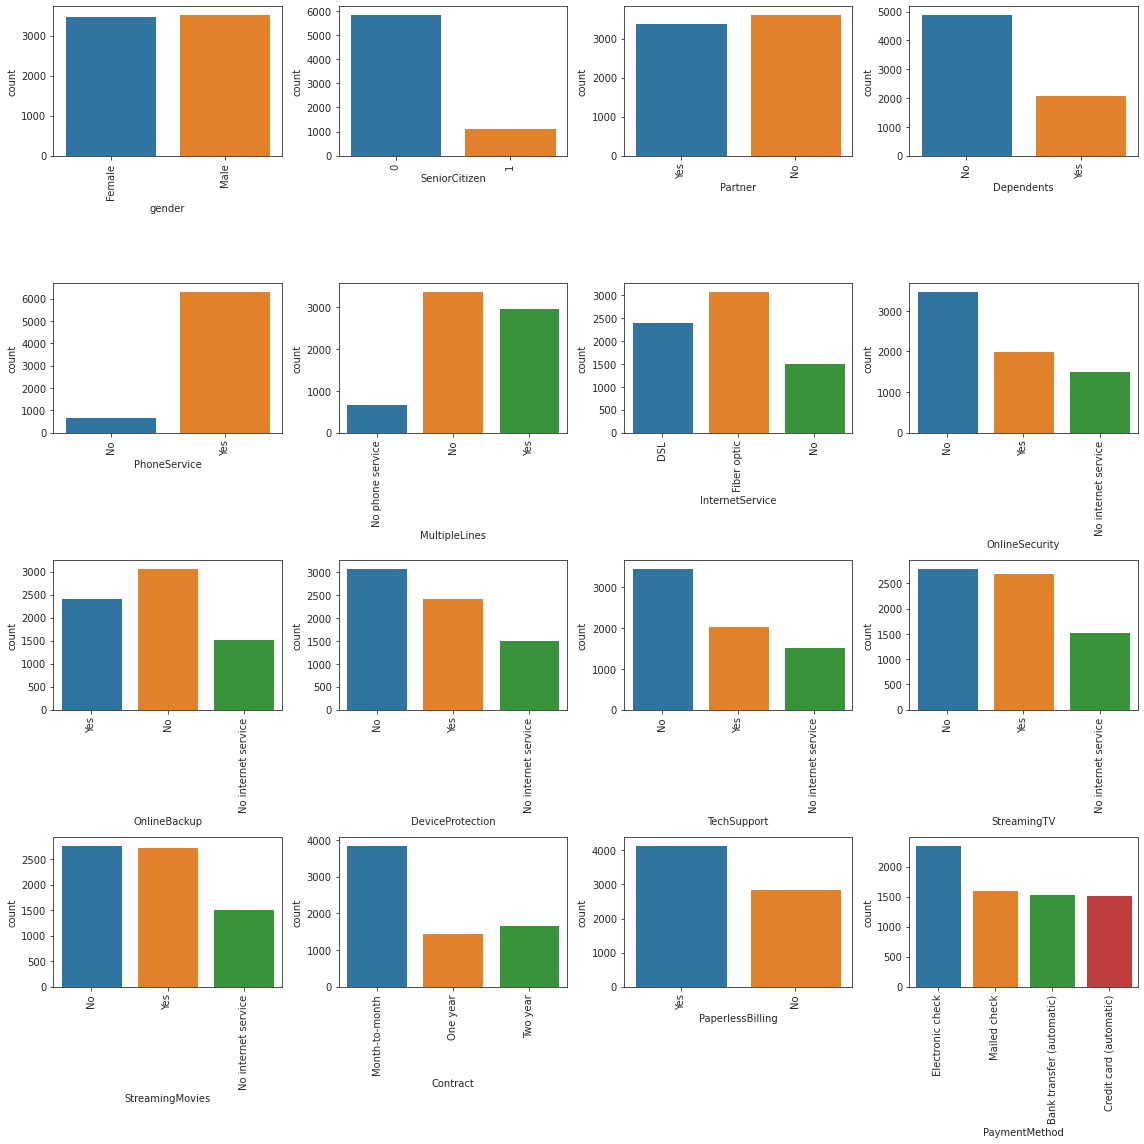

In [0]:
df_cat = churn_df[categorical_columns].copy()

plt.figure(figsize=(16,16))
for i in range(0,16):
        plt.subplot(4,4,i+1)
        sns.countplot(df_cat.iloc[:,i])
        plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [0]:
def plot_distribution_num(data_select) : 
    sns.set_style("ticks")
    s = sns.FacetGrid(churn_df, hue = 'Churn',aspect = 1.5,palette = 'pastel')
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.8)
    s.set(xlim=(0, churn_df[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

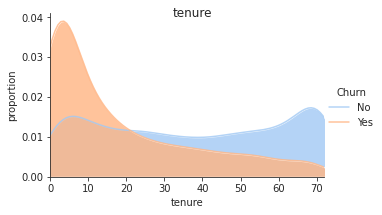

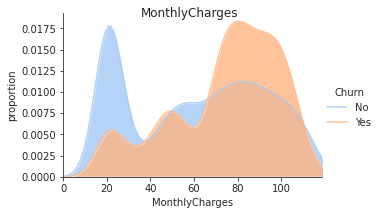

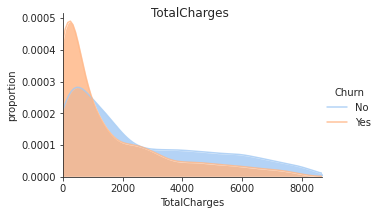

In [0]:
plot_distribution_num('tenure')
plot_distribution_num('MonthlyCharges')
plot_distribution_num('TotalCharges')

#### Target variable distribution





In [0]:
trace = go.Pie(labels = ['Churn : no', 'Churn : yes'], values = churn_df['Churn'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict( colors=['lightblue','sandybrown'],
                           line=dict(color='#000000', width=1.5)))
layout = dict(title =  'Distribution of target variable', autosize=False, height = 300, width = 500)

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [0]:
# Prep Data: Remove non-predictive ID 
churn_df = churn_df.drop(columns='customerID',axis=1)

In [0]:
# Use one hot encoder to encode categorical varibles
churn_encoded = pd.get_dummies(churn_df)

In [0]:
# Drop column Churn_No
churn_encoded = churn_encoded.drop(columns='Churn_No',axis=1)

In [0]:
# Remove collinear features
#Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = churn_encoded.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove :' % (len(to_drop)))

to_drop

There are 12 columns to remove :


['gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'PaperlessBilling_Yes']

In [0]:
 churn_cleaned = churn_encoded.drop(columns = to_drop)

#### Survival Analysis

Text(0.5, 0, 'Days after purchase')

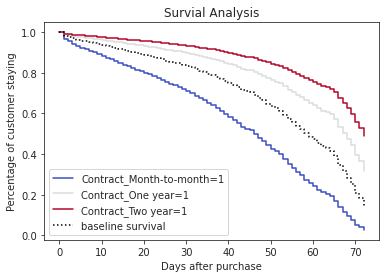

In [0]:
cph = CoxPHFitter(penalizer=0.1,l1_ratio=1.0)
cph.fit(churn_cleaned, duration_col='tenure', event_col='Churn_Yes')

cph.plot_covariate_groups(['Contract_Month-to-month','Contract_One year','Contract_Two year'], np.eye(3),cmap='coolwarm')
plt.title('Survial Analysis')
plt.ylabel('Percentage of customer staying')
plt.xlabel('Days after purchase')

-  Customer Churn Problem Indentification: More than 50% of Month-to-month contract customers leave the company after 50 days of purchase

#### Deal with imbalance dataset

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_sample(churn_cleaned.drop(columns='Churn_Yes',axis=1), churn_cleaned['Churn_Yes'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
# oversampled_train.columns = normalized_df.columns

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



### 3. Model Building
#### 3.1 Random Forest Model

In [0]:
oversampled_X_train,oversampled_X_test,oversampled_Y_train,oversampled_Y_test = train_test_split(oversampled_X,oversampled_Y,test_size=0.3,random_state=42)
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}

# Fit RandomForest Classifier
clf2 = RandomForestClassifier(**params)
clf2 = clf2.fit(oversampled_X_train, oversampled_Y_train)
predict = clf2.predict(oversampled_X_test)
probs = clf2.predict_proba(oversampled_X_test)
score = clf2.score(oversampled_X_test,oversampled_Y_test)
print("Accuracy: ", score)

Accuracy:  0.8528180354267311


In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(oversampled_Y_test, probs[:,1])

0.9340483045438739

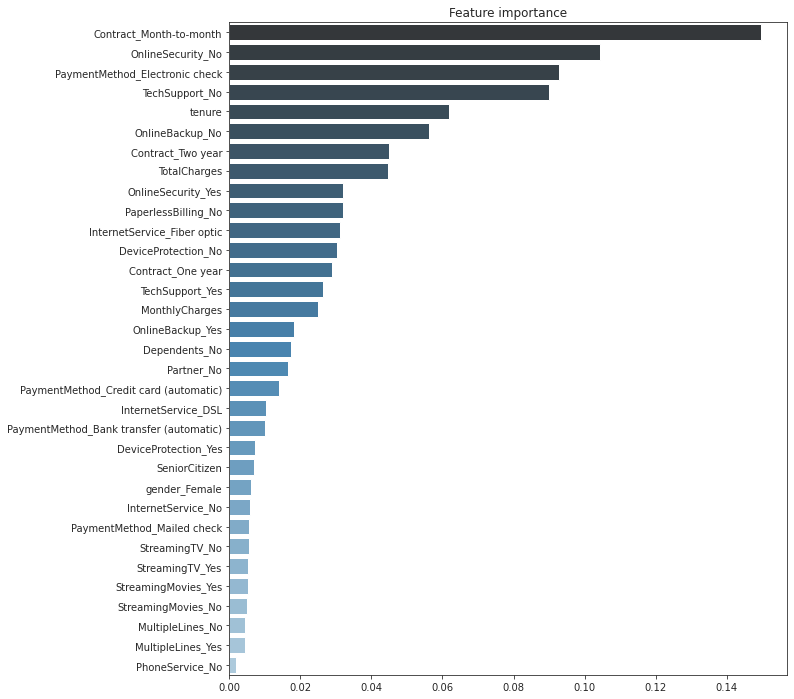

In [0]:
# Plot feature importance
x = churn_cleaned.drop('Churn_Yes',axis=1)
imp = pd.Series(data=clf2.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')



---




#### 3.2 H2O autoML model and explain it using LIME

In [0]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

In [0]:
# Using H2O to build model doesn't need to encode categorical variables, so we resample the original dataset again
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = churn_df[churn_df.Churn=='No']
df_minority = churn_df[churn_df.Churn=='Yes']
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=5174,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Churn.value_counts()

Yes    5174
No     5174
Name: Churn, dtype: int64

- Convert H2O frame to numpy array
 - The LIME explainer requires numpy arrays as input and H2O requires the train and test data to be in H2O frames. 
 - In this case we could just use the train and test numpy arrays but for illustrative purposes here is how to convert an H2O frame to a pandas dataframe and a pandas dataframe to a numpy array.

In [0]:
import sklearn
import sklearn.ensemble
data = df_upsampled
labels = data['Churn']
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data.iloc[:,:-1].to_numpy()

In [0]:
categorical_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16]
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data[:, feature])
    data[:, feature] = le.transform(data[:, feature])
    categorical_names[feature] = le.classes_

In [0]:
data = data.astype(float)

In [0]:
feature_names = df_upsampled.columns.to_list()
feature_names = feature_names[:-1]

In [0]:
# Split train and test set
np.random.seed(1)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80)

train_h2o_df = h2o.H2OFrame(train)
train_h2o_df.set_names(feature_names)
train_h2o_df['Churn'] = h2o.H2OFrame(labels_train)
train_h2o_df['Churn'] = train_h2o_df['Churn'].asfactor()

test_h2o_df = h2o.H2OFrame(test)
test_h2o_df.set_names(feature_names)
test_h2o_df['Churn'] = h2o.H2OFrame(labels_test)
test_h2o_df['Churn'] = test_h2o_df['Churn'].asfactor()

print(type(train_h2o_df))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
<class 'h2o.frame.H2OFrame'>


In [0]:
for feature in categorical_features:
    train_h2o_df[feature] = train_h2o_df[feature].asfactor()
    test_h2o_df[feature] = test_h2o_df[feature].asfactor()

In [0]:
# Build autoML model
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(feature_names, 'Churn', training_frame = train_h2o_df)
lb = aml.leaderboard
leader_model = aml.leader
perf = leader_model.model_performance(test_h2o_df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
perf.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5380154682424436: 


0       1   Error             Rate
0      0  941.0   108.0   0.103   (108.0/1049.0)
1      1   47.0   974.0   0.046    (47.0/1021.0)
2  Total  988.0  1082.0  0.0749   (155.0/2070.0)

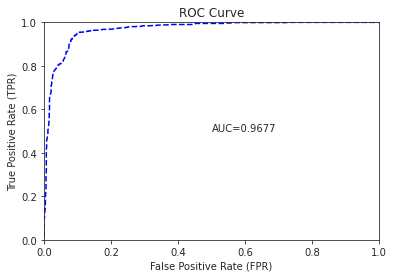

In [0]:
perf.plot()

#### 3.3 Explainable Model - Using Lime

In [0]:
# Create a function to get prediction from H2O model
class h2o_predict_proba_wrapper:
    # the column_names is the labels of the X values
    def __init__(self,model,column_names):
            
            self.model = model
            self.column_names = column_names
 
    def predict_proba(self,this_array):        
        # If we have just 1 row of data we need to reshape it
        shape_tuple = np.shape(this_array)        
        if len(shape_tuple) == 1:
            this_array = this_array.reshape(1, -1)
            
        # We convert the numpy array that Lime sends to a pandas dataframe and
        # convert the pandas dataframe to an h2o frame
        self.pandas_df = pd.DataFrame(data = this_array,columns = self.column_names)
        self.h2o_df = h2o.H2OFrame(self.pandas_df)
        
        # Predict with the h2o drf
        self.predictions = self.model.predict(self.h2o_df).as_data_frame()
        # the first column is the class labels, the rest are probabilities for
        # each class
        self.predictions = self.predictions.iloc[:,1:].values
        return self.predictions

In [0]:
h2o_drf_wrapper = h2o_predict_proba_wrapper(leader_model,feature_names)

In [0]:
explainer = lime.lime_tabular.LimeTabularExplainer(train ,feature_names = feature_names,class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names)

In [0]:
i = 30
exp = explainer.explain_instance(test[i], h2o_drf_wrapper.predict_proba, num_features=5)
exp.show_in_notebook(show_all=False)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
i = 48
exp = explainer.explain_instance(test[i], h2o_drf_wrapper.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=True)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
h2o.shutdown(prompt=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Deprecated, use ``h2o.cluster().shutdown()``.



H2O session _sid_bd20 closed.
